# Machine learning in bioinformatics

In this chapter we'll begin talking about machine learning algorithms. Machine learning algorithms are used in bioinformatics for tasks where the user would like an algorithm to assist in the identification of patterns in a complex dataset. As is typically the case in this book, we'll work through implementing a few algorithms but these are not the implementations that you should use in practice. The code is written to be accessible for learning. [scikit-learn](http://scikit-learn.org/) is a popular and well-documented Python library for machine learning which many bioinformatics researchers and software developers use in their work. If you'd like to start trying some of these tools out, scikit-learn is a great place to start. 

```{warning}
Machine learning algorithms can easily be misused, either intentionally or unintentionally, to provide misleading results. This chapter will cover some guidelines for how to use these techniques, but it is only intended as a primer to introduce machine learning. It's not a detailed discussion of how machine learning algorithms should and shouldn't be used. If you want to start applying machine learning tools in your own research, I recommend moving from this chapter to the scikit-learn documentation, and their content on [Common pitfalls and recommended practices](https://scikit-learn.org/stable/common_pitfalls.html).
```

## The feature table

Machine learning algorithms generally are provided with a table of **samples** and user-defined **features** of those samples. These data are typically represented in a matrix, where samples are the rows and features are the columns. This matrix is referred to as a **feature table**, and it is central to machine learning and many subfields of bioinformatics. The terms used here are purposefully general. Samples are intended to be any unit of study, and features are attributes of those samples. Sometimes **labels** or **response variables** will also be associated with the samples, in which case a different class of methods can be applied. 

scikit-learn provides a few example datasets that can be used for learning. Let's start by taking a look and one of them to get an idea of what input might look like in a machine learning task.

### The Iris dataset

The [Iris dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-plants-dataset) is a classic example used in machine learning, originally published by RA Fisher {cite}`Fisher1936-tk`. This feature table describes four features of 150 specimens of Iris, a genus of flowering plant, representing three species. The feature table follows:

In [1]:
# This cell loads data from scikit-learn and organizes it into some strcutures that
# we'll use to conveniently view the data.

import sklearn.datasets
import pandas as pd

iris_dataset = sklearn.datasets.load_iris(as_frame=True)
iris_feature_table = iris_dataset.frame.drop('target', axis=1)
iris_feature_table.index.name = 'sample-id'
# map target integers onto species names
iris_labels = pd.Series(iris_dataset.target_names[iris_dataset.target], 
                        index=iris_dataset.target.index, name='species').to_frame()
iris_labels.index.name = 'sample-id'

In [2]:
iris_feature_table

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sample-id,,,,
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0


The rows in this table represent our samples - in this case specimens of Iris. The columns represent features, or attributes of the samples. Each **sample vector** (i.e., row) will include a unique identifier for the sample which we usually call the _sample id_ (here these are simply integers), and values for each feature for that sample. Each **feature vector** (i.e., column) will similarly contain an identifier for the feature, or the the _feature id_. These are often simplistic descriptions of the features, as they are in this example, but they don't need to be (integers would work fine as feature ids). The feature vector then contains the values measured for that feature in each sample.

This feature table on its own can serve as an input dataset for unsupervised learning tasks, which we'll cover first in this chapter. A goal of unsupervised learning might be to determine if there are groups of samples that are most similar to one another. 

In addition to this feature table, the Iris dataset contains labels for each of the 150 samples indicating which species each sample belongs to:

In [3]:
iris_labels

,species
sample-id,
0,setosa
1,setosa
2,setosa
3,setosa
4,setosa
...,...
145,virginica
146,virginica
147,virginica


The sample ids in this label vector must be the same as the sample ids in the feature table. The feature table and the sample labels together can be used as input data for supervised learning tasks, which we'll cover second in this chapter. A goal of supervised learning might be to develop a classifier that could report the species of an Iris if provided with values for its sepal length and width and its petal length and width (i.e., the features that the algorithm originally had access).

There are three different labels, or classes, in this dataset:

In [4]:
iris_labels['species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

## Unsupervised versus supervised learning methods

Many machine learning methods are classified at a high level as either unsupervised or supervised learning methods. 

In **unsupervised learning** we either don't have or don't use sample labels, and the algorithm therefore operates on a feature table alone. Typically the user is hoping to discover some structure in the data that can help them to understand which samples are most similar to each other based on their feature values. In this chapter we'll introduce ordination as an unsupervised learning task. Ordination is very widely used in biology - you may have already encountered ordination plots (such as PCoA or NMDS plots) in some of your own work. 

In **supervised learning**, on the other hand, sample labels are used in addition to a feature table. The sample labels can be discrete, as in the Iris dataset, or continuous, and that distinction defines whether we're working on a classification or regression task, respectively. The goal of a supervised learning task is typically to have the computer develop a model that can accurate predict an unlabeled sample's label from its feature values (for example, what species does an Iris specimen belong to, based on its sepal and petal length and width).

## Machine learning methods applied to microbial sequence data

In [5]:
# This cell performs some configuration for this notebook. It's hidden by
# default because it's not relevant to the content of this chapter. You'll
# occasionally notice that I hide this type of information so it's not 
# distracting.

%pylab inline

import pandas as pd
import skbio
import numpy as np
import itertools
import collections
import random

Populating the interactive namespace from numpy and matplotlib


In this chapter, we'll work with 16S rRNA data [as we did previously](load-qdr). Specifically, we'll load sequences from the Greengenes database and construct a feature table from them. We'll use this feature table in an unsupervised learning task and a supervised learning task. We'll also load labels for the sequences which we'll primarily use in our supervised learning task, but which we'll also use to aid in interpretation in our unsupervised learning task. 

Our goal with these tasks will be to explore species-level taxonomy of a few microbial species based on sequence data. In our unsupervised learning task, we'll determine if samples (i.e., sequences) coming from the same species appear to generally be more similar to each other than samples coming from different species. In our supervised learning task, we'll determine if we can develop a classifier to predict microbial species from an unlabeled sequence. 

Let's start by loading five sequences from each of five specific microbial species from Greengenes.

In [6]:
import collections
import qiime_default_reference as qdr
import skbio

def load_annotated_sequences(taxa_of_interest, class_size=None, sequence_length=500, 
                             verbose=True, ids_to_exclude=None):
    
    # Load the taxonomic data
    result = {}
    SequenceRecord = collections.namedtuple(typename='SequenceRecord',
                                            field_names=['identifier', 'split_taxonomy', 'taxonomy', 'sequence'])
    
    taxon_to_sequence_records = {t: list() for t in taxa_of_interest}        
    
    id_to_taxonomy_record = {}
    for line in open(qdr.get_reference_taxonomy()):
        identifier, taxonomy = line.strip().split('\t')
        id_to_taxonomy_record[identifier] = taxonomy
    
    for seq in skbio.io.read(qdr.get_reference_sequences(), format='fasta', 
                             constructor=skbio.DNA):
        identifier = seq.metadata['id']
        if ids_to_exclude is not None and identifier in ids_to_exclude:
            # if this id was tagged to not be included in the result, 
            # move on to the next record
            continue
        
        tax = id_to_taxonomy_record[identifier]
        split_taxonomy = [e.strip() for e in tax.split(';')]
        taxonomy = ';'.join(split_taxonomy)
        if taxonomy not in taxon_to_sequence_records:
            # if this is not one of the taxa that we're interested in, 
            # move on to the next record. 
            continue
        
        if seq.has_degenerates():
            # for the purpose of this exercise we'll skip records 
            # that have non-ACGT characters. if degenerate characters
            # are present, move on to the next record
            continue
            
        if sequence_length is not None:
            sequence = seq[:sequence_length]
        else:
            sequence = seq

        sr = SequenceRecord(identifier=identifier,
                            split_taxonomy=split_taxonomy,
                            taxonomy=taxonomy,
                            sequence=sequence)
        taxon_to_sequence_records[taxonomy].append(sr)
        
    if verbose:
        for taxon, srs in taxon_to_sequence_records.items():
            print("%d sequences were identified for taxon %s." % (len(srs), taxon))
    
    if class_size is None:
        result = {sr.identifier: sr for srs in taxon_to_sequence_records.values() for sr in srs}
    else:
        result = {}
        for taxon, srs in taxon_to_sequence_records.items():
            if class_size > len(srs):
                raise ValueError("Class size (%d) too large for taxon %s, which has only %d non-degenerate sequences." % 
                                 (class_size, t, len(srs)))
            sampled_sequence_records = random.sample(srs, k=class_size)
            result.update({sr.identifier: sr for sr in sampled_sequence_records})

    return result

(ml:define-sequences-per-speciesm)=

In [7]:
taxa_of_interest = {
    'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__stercorea',
    'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__copri',
    'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__melaninogenica',
    'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__succinicans',
    'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Propionibacteriaceae;g__Propionibacterium;s__acnes',
    'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__veronii',
    'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__viridiflava'
}
sequences_per_taxon = 5

seq_data = load_annotated_sequences(taxa_of_interest, class_size=sequences_per_taxon)

15 sequences were identified for taxon k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__succinicans.
127 sequences were identified for taxon k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Propionibacteriaceae;g__Propionibacterium;s__acnes.
26 sequences were identified for taxon k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__melaninogenica.
35 sequences were identified for taxon k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__stercorea.
17 sequences were identified for taxon k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__viridiflava.
24 sequences were identified for taxon k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__veronii.
121 sequences were identified for taxon k__Bacteria;p__Bacte

We can look at a few randomly selected records from the data that was just compiled as follows. For each, we have a unique identifier, the source species for the sequence record, and a 16S rRNA sequence.

In [8]:
for sr in random.sample(list(seq_data.values()), 3):
    print(sr.identifier)
    print(sr.taxonomy)
    print(sr.sequence)
    print('🦠')

970921
k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__succinicans
GATGAACGCTAGCGGCACGCTTAACACATGCAAGTCGAGGGGTATAAGTCTTCGGATTTAGAGACCGGCGCACGGGTGCCTAACCCGTATGCTATCTACCTTTTACAGAGGGATAGCCCATACAAATTTGGATTAATACCTCATAACATAGCAATCTCGCATGACATCGCTATTAAAGTCACGACGGTCAAAGATGAGCATGCCTCCCATTAGCTACTTGGTAACGTAACGGCTTACCAAGGGTACTATGGGTAGGGGTCCTGAAAGGGAGATCCCCCACACTGGTACTGAGACCCCGACCATACTCCCACGGGAGGCAGAATCGAGGAATATTGGACAATGGGCACTAGCCTGATCCAGCCATGCCGCGTGCACGATGACGGTCCTATGGATTGTAAACTGCTTTTATACTAGAACACACACTCCTTCGAGAAGGAATTTGACTGTATCGTAACAATAAGGATCGGCTAACTCCGTGCCAGCAGCCGCTGTAATACTGA
🦠
299830
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__copri
TAGAGTTTGATCCTGGCTCAGGATGAACGCTAGCTACAGGCTTAACACATGCAAGTCGAGGGGCAGCATGACGGAAGCTTGCTTTCGTTGATGGCGACCGGCGCACGGGTGAGTAACGCGTATCCAACCTGCCCTTGTCCATCGGATAACCCGTCGAAAGGCGGCCTAACACGATATGCGGTTCACCGCAGGCATCTAACGTGAACGAAATGTGAAGGAGAAGGATGGGGATGCGTCTGATTAGCTTGTTGGTGGGGTAA

The first thing we need to generate from these data is our feature table, which raises the question of which features we want our machine learning algorithms to work with. In the last chapter, we discussed k-mers are length-k stretches of adjacent characters in a sequence. Those k-mers helped us to identify relevant sequences in our database searching, so they may be useful here as well. We don't necessarily know how long our k-mers should be (i.e., what value `k` should be set to) however. The longer our kmers, the more likely they are to be specific to certain taxa, which is helpful for machine learning tasks. However, if they get too long it becomes less likely that we'll observe those kmers in other sequences because the longer a k-mer sequence is, the more likely we are to see variation across closely related organisms. This is a problem for machine learning tasks, because we need to identify features that are shared among related samples.

 Let's set $k=4$, and use k-mers as the features that will define our sequence records for the examples in this chapter. I chose this value of $k$ for our work here based on experimentation with multiple Greengenes subsamples. The features could be based on different values of $k$, or other features of sequences that you identify. If you have ideas about other values that you could compute from these sequences, come back here and try it out after you've finished reading this chapter.

(ml:define-k)=

In [9]:
k = 4

In [10]:
def feature_table_from_sequence_records(sequence_records, k):
    kmer_frequencies = {id_ : sr.sequence.kmer_frequencies(k=k) for id_, sr in sequence_records.items()}
    result = pd.DataFrame(kmer_frequencies).fillna(0).astype(int).T
    result.index.name = 'id'
    return result

After extracting all k-mers from the sequences and putting them in a table where the rows are our sequences (indexed by the unique sequence identifiers), the columns represent unique k-mers (labeled by the k-mer itself), and the values are the number of times each k-mer is observed in each sequence, we end up with our feature table for unsupervised and supervised learning.

In [11]:
sequence_feature_table = feature_table_from_sequence_records(seq_data, k)
sequence_feature_table[:12]

,GATG,ATGA,TGAA,GAAC,AACG,ACGC,CGCT,GCTA,CTAG,TAGC,...,CCCT,GCTC,GCGA,TTGC,CGCC,TGTG,CTCT,TTCC,GTTC,ATTC
id,,,,,,,,,,,,,,,,,,,,,
1020921,4,3,2,2,4,2,1,3,1,3,...,0,0,0,0,0,0,0,0,0,0
1111241,5,2,2,1,3,1,0,3,1,2,...,0,0,0,0,0,0,0,0,0,0
241971,6,5,4,3,4,2,1,4,1,5,...,0,0,0,0,0,0,0,0,0,0
970921,3,4,2,2,3,2,4,5,3,5,...,0,0,0,0,0,0,0,0,0,0
867450,5,3,2,1,4,2,1,4,2,3,...,0,0,0,0,0,0,0,0,0,0
4226754,3,1,1,3,4,2,2,2,0,1,...,2,2,2,1,2,1,0,0,0,0
403853,3,1,0,1,2,1,1,2,0,1,...,2,3,2,1,2,2,0,0,0,0
862869,2,1,1,4,4,2,4,2,0,1,...,2,2,2,3,4,5,0,0,0,0
4121939,3,1,0,3,4,2,2,2,0,1,...,2,2,2,1,2,2,0,0,0,0


As mentioned above, supervised learning tasks also require labels. In this example, the labels will be the species that each sequence was identified in. We'll next compile our sample label vector.

In [12]:
def feature_labels_from_sequence_records(sequence_records):
    result = pd.DataFrame({id_:sr.split_taxonomy for id_, sr in sequence_records.items()}).T
    result.columns = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']
    result.index.name = 'id'
    legend_entries = []
    for _, (g, s, p) in result[['genus', 'species', 'phylum']].iterrows():
        legend_entries.append('%s %s (%s)' % (g[3:], s[3:], p[3:]))
    result['legend entry'] = legend_entries
    return result

In [13]:
sequence_labels = feature_labels_from_sequence_records(seq_data)
sequence_labels[:12]

,domain,phylum,class,order,family,genus,species,legend entry
id,,,,,,,,
1020921,k__Bacteria,p__Bacteroidetes,c__Flavobacteriia,o__Flavobacteriales,f__Flavobacteriaceae,g__Flavobacterium,s__succinicans,Flavobacterium succinicans (Bacteroidetes)
1111241,k__Bacteria,p__Bacteroidetes,c__Flavobacteriia,o__Flavobacteriales,f__Flavobacteriaceae,g__Flavobacterium,s__succinicans,Flavobacterium succinicans (Bacteroidetes)
241971,k__Bacteria,p__Bacteroidetes,c__Flavobacteriia,o__Flavobacteriales,f__Flavobacteriaceae,g__Flavobacterium,s__succinicans,Flavobacterium succinicans (Bacteroidetes)
970921,k__Bacteria,p__Bacteroidetes,c__Flavobacteriia,o__Flavobacteriales,f__Flavobacteriaceae,g__Flavobacterium,s__succinicans,Flavobacterium succinicans (Bacteroidetes)
867450,k__Bacteria,p__Bacteroidetes,c__Flavobacteriia,o__Flavobacteriales,f__Flavobacteriaceae,g__Flavobacterium,s__succinicans,Flavobacterium succinicans (Bacteroidetes)
4226754,k__Bacteria,p__Actinobacteria,c__Actinobacteria,o__Actinomycetales,f__Propionibacteriaceae,g__Propionibacterium,s__acnes,Propionibacterium acnes (Actinobacteria)
403853,k__Bacteria,p__Actinobacteria,c__Actinobacteria,o__Actinomycetales,f__Propionibacteriaceae,g__Propionibacterium,s__acnes,Propionibacterium acnes (Actinobacteria)
862869,k__Bacteria,p__Actinobacteria,c__Actinobacteria,o__Actinomycetales,f__Propionibacteriaceae,g__Propionibacterium,s__acnes,Propionibacterium acnes (Actinobacteria)
4121939,k__Bacteria,p__Actinobacteria,c__Actinobacteria,o__Actinomycetales,f__Propionibacteriaceae,g__Propionibacterium,s__acnes,Propionibacterium acnes (Actinobacteria)


Our data is ready, so let's get started with unsupervised learning. 

## Unsupervised learning

We'll begin our exploration of machine learning approaches with unsupervised learning, and specifically with ordination. We'll work through ordination in two strokes. First, we'll explore an approach called **Polar Ordination**, where the math is simple but which isn't widely used in practice because more informative techniques exist. Working through this on a small data set will give you an idea of how ordination techniques can reduce the dimensionality of a data set and how to interpret the results of an ordination. Then, we'll apply an approach called **Principal Coordinates Analysis (PCoA)**. The math for PCoA is a bit more complicated than I want get into this book, but we'll look at how to apply PCoA using scikit-bio.

### Computing distances between samples

Most ordination techniques begin with computing **distances** between all pairs of samples. A simple and useful way to define distances between our samples is by computing the fraction of k-mers that are unique to either sample. This is known as the Jaccard Distance between the samples. This metric derives from set theory, and is the inverse of the Jaccard Index (or Jaccard Similarity). It is defined as follows:

```{math}
:label: jaccard_sim
Jaccard \, Index_{(A,B)} = \frac{| A \cap B |}{| A \cup B |}
```

Let's break this formula down. First, $(A,B)$ defines the two samples we're computing distances between. We refer to them here with the variables $A$ and $B$. $| A \cap B |$ is the count of features that are observed, or that have a value of one or more, in both samples. If you've studied set theory, you may recognize this as the size of the intersection of the sets of k-mers in samples $A$ and $B$. That number is divided by $| A \cup B |$, which is the count of features that are observed in either or both of the samples. In set theory terminology, this is the size of the union of the sets of k-mers in samples $A$ and $B$. The resulting value is a measure of the similarity of the two samples. To make this a distance, we simply subtract that value from 1. 

```{math}
:label: jaccard_dist
Jaccard \, Distance_{(A,B)} = 1 - Jaccard \, Index_{(A,B)}
```

If we apply this computation to all pairs of samples in our feature table, we can store the results in a **distance matrix**. This can be computed from our feature table as follows using scikit-bio.

In [14]:
import skbio.diversity

sequence_distance_matrix = skbio.diversity.beta_diversity('jaccard', sequence_feature_table, ids=sequence_feature_table.index)

/usr/share/miniconda/envs/iab2/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


A convenient way to get an initial glance at patterns in a small dataset like the one we're working with here would be to plot the distance matrix as a heatmap. Here, colors represent the distances and larger distances imply that a pair of samples are dissimilar from each other in their kmer content. 

Notice that the values along the diagonal are zero: this is because the diagonal represents distances between a sequence and itself, which is always zero. In other words, $Jaccard \, Distance_{(A,A)} = 0$. Also notice that the matrix is symmetric, meaning that if you were to flip the values across the diagonal they would be equal to each other. In other words, $Jaccard \, Distance_{(A,B)} = Jaccard \, Distance_{(B,A)}$.

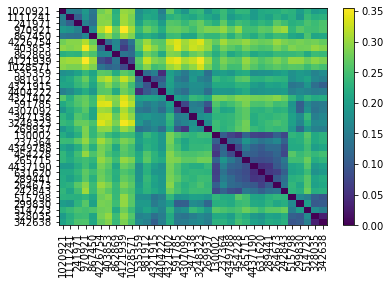

In [15]:
sequence_distance_matrix

```{admonition} Exercise
If you refer back to the table of our sample labels (defined in the `sequence_labels` variable) above, do you notice any patterns emerging from this heatmap?
```

If you want to look up the distance between a specific pair of samples, you can do that as follows:

In [16]:
sample_id1 = sequence_feature_table.index[0]
sample_id2 = sequence_feature_table.index[1]
d = sequence_distance_matrix[sample_id1, sample_id2]
print('The Jaccard Distance between samples %s and %s is %1.3f.' % (sample_id1, sample_id2, d))

The Jaccard Distance between samples 1020921 and 1111241 is 0.150.


### Polar ordination

Now that we have distances between all pairs of samples, we can perform a polar ordination on the samples. Results of ordination are typically viewed in a scatterplot with two or three dimensions, so I find it useful to think through polar ordination as an approach to build a scatterplot from this distance matrix. 

First, identify the largest distance in the distance matrix and note the sample ids associated with that distance. We'll refer to this distance as $D$.

In [17]:
sorted_indices = np.argsort(sequence_distance_matrix.data, axis=None)[::-1]
sorted_indices = np.unravel_index(sorted_indices, shape=sequence_distance_matrix.shape)
sample_id1 = sequence_distance_matrix.ids[sorted_indices[0][0]]
sample_id2 = sequence_distance_matrix.ids[sorted_indices[0][1]]
D = sequence_distance_matrix[sample_id1, sample_id2]
print('The largest distance in the distance matrix is %1.3f, between samples %s and %s.' % 
    (D, sample_id1, sample_id2))

The largest distance in the distance matrix is 0.355, between samples 970921 and 4121939.


These two samples define the first axis of your scatter plot. The length of this axis is $D$, and each sample will be placed at an endpoint on this axis. Choose one sample to be plotted at zero on this axis, and the other sample to plot at $D$ on this axis. It doesn't matter which sample you choose to plot at which endpoint. 

Next, we'll identify the location of every other samples on this first axis. For each sample $s$, this computed with the following formula.

```{math}
:label: polar-ordination-axis
A_s = \frac{D^2 + D1^2 - D2^2}{2 \times D}
```

In this formula, $A_s$ is the location of the current sample on the current axis. $D$ is the distance between the endpoints. $D1$ is distance between the current sample and the sample at $0$ on this axis, which you can look up in the distance matrix computed above. $D1$ is distance between the current sample and the sample at $D$ on this axis, which is also looked up in the distance matrix. 

The following Python function can be applied to compute the placement of all samples on a polar ordination axis, given the distances between all pairs of samples and the identifiers of the samples serving as the endpoints of this axis.

In [18]:
def compute_axis(dm, endpoint1, endpoint2):
    d = dm[endpoint1, endpoint2]
    result = {endpoint1: 0, endpoint2: d}
    non_endpoints = set(dm.ids) - set([endpoint1, endpoint2])
    for e in non_endpoints:
        d1 = dm[endpoint1, e]
        d2 = dm[endpoint2, e]
        result[e] = (d**2 + d1**2 - d2**2) / (2 * d)
    return pd.Series(result)

In [19]:
axis1_values = compute_axis(sequence_distance_matrix, 
                            sample_id1,
                            sample_id2)

At this stage, we have computed our first polar ordination axis. If we sort and view this axis we may even be able to see some clustering or grouping of samples along this axis.

In [20]:
axis1_values.sort_values()

970921     0.000000
241971     0.080489
867450     0.084018
1111241    0.093832
1020921    0.101953
3248323    0.110663
347138     0.115381
591785     0.116548
4321402    0.123459
515798     0.130300
981912     0.135637
4307092    0.137678
265715     0.138974
4404222    0.139079
328035     0.140359
299830     0.150428
4321915    0.151231
342638     0.156564
514723     0.157467
4437190    0.157514
535359     0.158603
269937     0.165551
289441     0.173129
4349788    0.178520
264673     0.183357
631620     0.184135
237364     0.189060
130002     0.205811
454228     0.206203
242843     0.206698
862869     0.257691
1028571    0.301334
4226754    0.305866
403853     0.345773
4121939    0.355372
dtype: float64

```{admonition} Exercise
If you again refer back to the table of our sample labels (defined in the `sequence_labels` variable) above, do you notice any patterns in the ordered samples along this axis?
```

We can plot this single axis using a strip plot. In this plot, only placement on the horizontal axis is meaningful. The variation in placement of points along the vertical axis is only to aid in visualization. In this plot, each point represents a single sample from our feature table. Samples that are closer in space along this axis are more similar to each other in their k-mer composition.

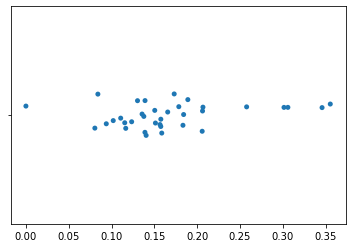

In [21]:
import seaborn as sns

_ = sns.stripplot(x=axis1_values)

While we may already be able to see some clustering of samples on the first axis, additional axes that are uncorrelated with this first axis can provide more information about which samples are most similar to each other. 

Selecting the next axes to plot in polar ordination is more complicated than choosing the first. Generally, you would begin by computing all axes, which would be defined for all pairs of samples. Then, you identify the axes that represent the largest distances (as we did for our first axis above), but that are also uncorrelated with previously selected axes. 

Let's start this by computing all polar ordination axes.

In [22]:
def polar_ordination(dm):
    result = {}
    for i, id1 in enumerate(dm.ids):
        for id2 in dm.ids[:i]:
            axis_label = '%s to %s' % (id1, id2)
            result[axis_label] = compute_axis(dm, id1, id2)
    result = pd.DataFrame(result)
    return result

We can apply this function to our distance matrix, and see all of the polar ordination axes.

In [23]:
sequence_polar_ordination = polar_ordination(sequence_distance_matrix)
sequence_polar_ordination

,1111241 to 1020921,241971 to 1020921,241971 to 1111241,970921 to 1020921,970921 to 1111241,970921 to 241971,867450 to 1020921,867450 to 1111241,867450 to 241971,867450 to 970921,...,342638 to 265715,342638 to 4437190,342638 to 631620,342638 to 289441,342638 to 264673,342638 to 242843,342638 to 515798,342638 to 299830,342638 to 514723,342638 to 328035
1020921,0.150215,0.146018,0.047244,0.188841,0.126809,0.123595,0.140969,0.057069,0.059137,0.034827,...,0.090745,0.112010,0.086142,0.096484,0.091427,0.086229,-0.000239,0.069525,0.045682,0.089937
1028571,0.057949,0.055256,0.052957,0.116924,0.128346,0.121467,0.055764,0.070843,0.068727,0.044327,...,0.076107,0.086698,0.103087,0.102166,0.087414,0.106500,0.011588,0.020975,0.089545,-0.068627
1111241,0.000000,0.034359,0.106195,0.121835,0.181435,0.147272,0.054329,0.134199,0.090732,0.037489,...,0.125775,0.135028,0.110808,0.132479,0.106107,0.129468,0.049989,0.128384,0.055548,0.044616
130002,0.043865,0.080792,0.107992,0.180682,0.206366,0.175371,0.094276,0.127062,0.081859,0.004313,...,0.199372,0.215031,0.217350,0.214494,0.199590,0.212951,0.032673,0.055750,0.020269,0.095954
237364,0.073785,0.119687,0.119149,0.174917,0.175594,0.131477,0.095949,0.095328,0.039813,0.012330,...,0.152496,0.168793,0.181711,0.176570,0.162770,0.198412,0.066947,0.055750,0.032158,0.095954
241971,0.041676,0.000000,0.000000,0.100912,0.125153,0.154185,0.054310,0.087531,0.129464,0.061388,...,0.133957,0.139243,0.121342,0.142736,0.096525,0.122890,0.122891,0.107102,0.077681,0.104803
242843,0.041527,0.093675,0.129014,0.195946,0.224189,0.181865,0.082909,0.117739,0.054952,-0.022832,...,0.181203,0.185950,0.197659,0.187156,0.180439,0.225000,0.032545,0.055752,-0.004884,0.045223
264673,0.085438,0.142716,0.134332,0.192688,0.184444,0.131433,0.107171,0.094073,0.026058,0.001592,...,0.190645,0.189863,0.202339,0.191041,0.213389,0.171127,-0.001766,0.055362,-0.002120,0.092829
265715,0.052104,0.081399,0.097173,0.113181,0.129289,0.092124,0.070485,0.092848,0.055269,0.061166,...,0.232365,0.216483,0.219110,0.215744,0.207599,0.187134,0.013984,0.022814,0.006204,0.098638
269937,0.105687,0.147911,0.112832,0.215325,0.191239,0.154238,0.139274,0.105129,0.055154,0.003109,...,0.000644,0.016084,0.018297,0.028580,0.029665,0.034975,-0.020625,0.095492,0.032845,-0.002020


This isn't much (or any) more interpretable than the distance matrix itself was, so the next step is to select the most informative axes to view. The first (most informative) axis will still be the axis that we identified above as the one representing the largest distance in the distance matrix. The second will be an axis that also contains a large distance (relative to the other distances in the distance matrix), and which is uncorrelated with the first axis. Selecting this axis based on these two criteria is subjective, because there is not a specific definition of "uncorrelated". We need to come up with an objective approach so a computer can solve the problem. Here, I define a _score_ metric that can be computed for each axis. This score is computed as the largest distance along the current axis divided by the absolute value of the Spearman correlation coefficient between the current axis and the first axis. In other words:

```{math}
:label: polar_ordination_axis_score
Score_{A} = \frac{max \, distance \, on \, A}{|Spearman(Axis \, 1, A)|}
```

In this formula, $A$ represents the current axis, and $Axis 1$ represents the first axis in the polar ordination.

This can be computed as follows. This function takes a polar ordination result as input and returns the identifiers of the first two axes as well as a summary of the maximum distance along each axis, the correlation of each axis with the first axis, and the score (as defined by {eq}`polar_ordination_axis_score`) for each axis.

In [24]:
def select_polar_ordination_axes(polar_ordination):
    # this function would be better if it defined more axes, 
    # eg by always looking for correlation with preceding axis. 
    distance_sorted_ord_axes = polar_ordination.max().sort_values(ascending=False)
    first_axis_idx = distance_sorted_ord_axes.index[0]
    corrs = polar_ordination.corrwith(polar_ordination[first_axis_idx], method='spearman').abs().sort_values(ascending=False)
    scores = distance_sorted_ord_axes / corrs
    result = pd.concat([distance_sorted_ord_axes, corrs, scores], axis=1)
    result.columns = ['maximum distance', 'corr with first axis', 'score']
    result.sort_values(by='score', ascending=False, inplace=True)
    second_axis_idx = result.index[0]
    return first_axis_idx, second_axis_idx, result

In [25]:
first_axis_idx, second_axis_idx, axis_summaries = select_polar_ordination_axes(sequence_polar_ordination)
print('Axis 1 is defined by the distance from sample %s' % first_axis_idx)
print('Axis 2 is defined by the distance from sample %s' % second_axis_idx)

Axis 1 is defined by the distance from sample 4121939 to 970921
Axis 2 is defined by the distance from sample 289441 to 862869


For each axis, we can view the maximum distance along that axis, it's correlation coefficient with the first axis, and the score of the axis, by viewing the summary returned from `select_polar_ordination_axes`.

In [26]:
axis_summaries

,maximum distance,corr with first axis,score
289441 to 862869,0.231469,0.000560,413.171897
3248323 to 4321402,0.229508,0.001821,126.044136
631620 to 4226754,0.272340,0.002241,121.531915
299830 to 241971,0.230453,0.002801,82.265843
264673 to 4226754,0.300847,0.007003,42.961017
...,...,...,...
4321915 to 981912,0.092920,0.562745,0.165120
1028571 to 4121939,0.114260,0.698319,0.163621
4437190 to 454228,0.105727,0.694678,0.152196
4307092 to 591785,0.076598,0.544258,0.140739


Now we can expand our strip plot to a two-dimensional scatter plot where we plot the first two axes of our polar ordination. You should notice that there is some grouping or clustering of samples in this plot. This group should be more distinct than it was in the strip plot, since our samples can now separate along two axes.

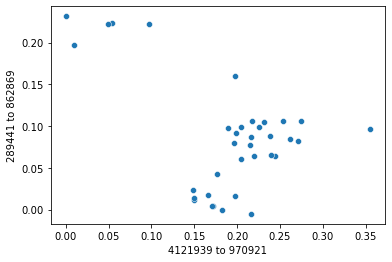

In [27]:
_ = sns.scatterplot(x=sequence_polar_ordination[first_axis_idx], 
                    y=sequence_polar_ordination[second_axis_idx])

This plot illustrates that there is some structure in our dataset. If you look up distances between samples that are closer to each other in space in the scatterplot, those distances on average will be smaller than the distances between samples that are farther apart in the scatterplot. This structure in the dataset is what has been "learned" by the polar ordination algorithm. Notice that the sequence labels were not used at all in this analysis, but if you look up where each sample is found on the plot, and cross-reference that against the sample labels, you'll discover that samples that cluster together are from the same species. 

When labels are available for a collection of samples, labels can be used with an ordination plot to explore whether samples cluster by sample label. This is often achieved by coloring the points in a scatterplot by their label. We can do this for our sequence ordination as follows. Notice that the colors (the microbial species represented in our dataset) group together.

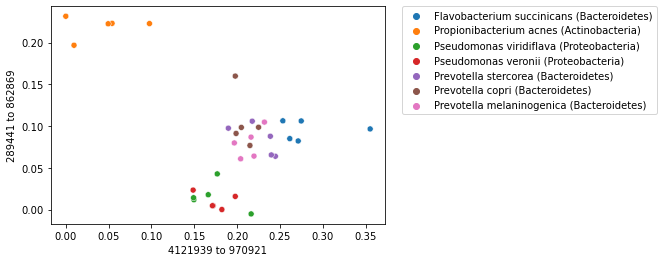

In [28]:
import matplotlib.pyplot as plt

_ = sns.scatterplot(x=sequence_polar_ordination[first_axis_idx], 
                    y=sequence_polar_ordination[second_axis_idx], 
                    hue=sequence_labels['legend entry'])
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

```{note}
Remember that while we used the sample labels to help us interpret the ordination plot, they were not used at all in computing the ordination. Not using the labels when computing the ordination is what defines this ordination approach as being unsupervised.
```

### Interpreting ordination plots

Let's now work through some of the ideas we explored with polar ordination to understand general features of unsupervised ordination plots. 

#### Axis order

First, the order of the axes in an ordination is generally important. The first axis typically represents in the largest differences in the data set, and the second axis generally presents the next largest differences that are uncorrelated with the first axis. If we didn't select axes that represented the largest distances, we would be less likely to see patterns in our data. 

For example, let's focus on just a single axis again. We can sort our axis summary by maximum distance along an axis, and plot the axes that represent the largest and then the smallest distances.

In [29]:
distance_sorted_axis_summary = axis_summaries.sort_values(by='maximum distance', ascending=True)

First, we'll plot our samples along the axis representing the largest distance and we'll separate the samples by species so we can see how their placement along the axes we define differ. You should notice here that the samples within each species roughly group together, and there may even be some separation of species on the axis.

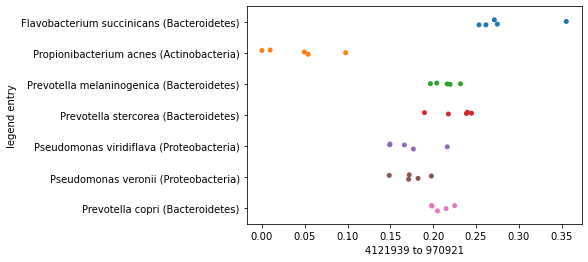

In [30]:
largest_distance_axis_idx = distance_sorted_axis_summary.index[-1]
_ = sns.stripplot(x=sequence_polar_ordination[largest_distance_axis_idx], 
                  y=sequence_labels['legend entry'])

Now contrast this with what we'd see if we generated this same plot, but based on the smallest distance in the distance matrix rather than the largest. Clustering of samples by species should be much less apparent here.

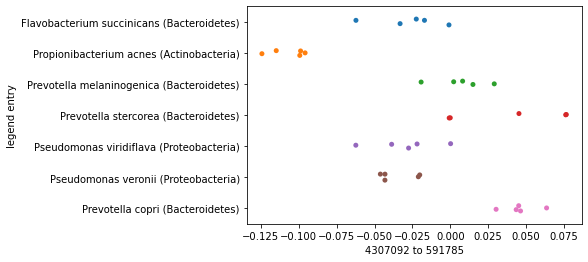

In [31]:
smallest_distance_axis_idx = distance_sorted_axis_summary.index[0]

_ = sns.stripplot(x=sequence_polar_ordination[smallest_distance_axis_idx], 
                  y=sequence_labels['legend entry'])

As you plot successive axes in an ordination, the axes represent smaller differences between samples. Typically you'll want to focus on the first few ordination axes to the exclusion of later axes.

#### Uncorrelated axes

Next, ordination algorithms generally present uncorrelated axes as the most important axes. This is important because correlated axes, by definition, will present similar information. 

Let's look at another example here where we'll plot a second polar ordination axis that is highly correlated with the first axis.

In [32]:
# the axis most correlated with first_axis_idx will be first_axis_idx, so 
# select the second axis
correlated_axis_idx = axis_summaries.sort_values(by='corr with first axis', ascending=False).index[1]

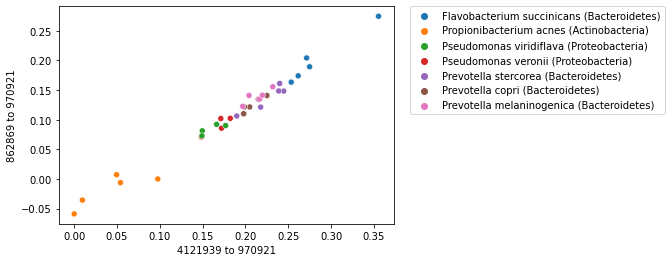

In [33]:
_ = sns.scatterplot(x=sequence_polar_ordination[first_axis_idx], 
                    y=sequence_polar_ordination[correlated_axis_idx], 
                    hue=sequence_labels['legend entry'])
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

You can see that we don't get much additional information from the second axis than we do from the first. In fact, if we drew a line along the diagonal, the placement of points along that line would be almost identical to those that we observed in the strip plot of the first axis that we started with above. The correlated axis isn't adding much new information to our understanding of the clustering of samples, so we might as well not have it.

#### Directionality of the axes

One thing that you may have noticed as you computed the polar ordination above is that our definitions of end points was arbitrary. We first encountered this when computing {eq}`polar-ordination-axis`, when we defined one of a pair of samples to be placed at $0$ along an axis, and the other of the pair of samples to be placed at $D$ along the axis. Let's again look at placement of all samples along the axis represented the largest distance in our data set computed as we did initially.

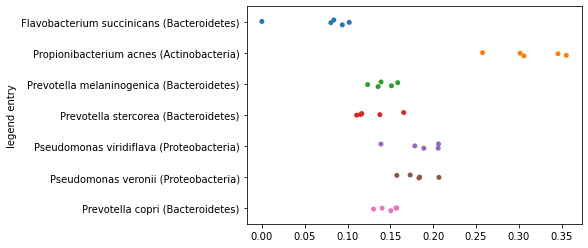

In [34]:
axis1_values_a = compute_axis(sequence_distance_matrix, 
                              sample_id1,
                              sample_id2)

_ = sns.stripplot(x=axis1_values_a, 
                  y=sequence_labels['legend entry'])

Now, let's reverse the order of the sample ids that we're providing as input to this function. In practice, this means that the sample that was previously placed at $0$ will now be placed at $D$ along this axis, and the sample that was previously placed at $D$ will now be placed at $0$ along this axis.

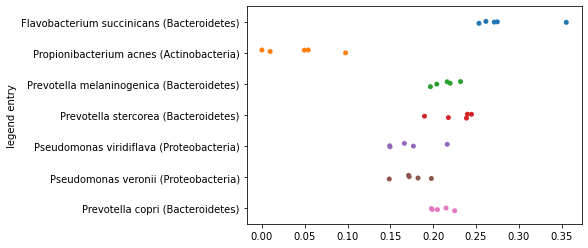

In [35]:
axis1_values_b = compute_axis(sequence_distance_matrix, 
                              sample_id2,
                              sample_id1)

_ = sns.stripplot(x=axis1_values_b, 
                  y=sequence_labels['legend entry'])

Notice that these two plots are mirror images of each other. Because they're perfectly anti-correlated, they present identical information about the grouping of the samples. This will be true for any axis in our ordination, and for this reason the directionality of the axes in an ordination is not meaningful. You can always flip an axis and have the same result. You may also notice that if you run the same ordination multiple times, the directionality of the axes might change across runs. This is typically a result of how the algorithm is implemented, and it doesn't impact your results at all. 

### Principal Coordinates Analysis (PCoA)

Finally, lets conclude our introduction to unsupervised learning by plotting these same data using principal coordinates analysis, or PCoA. As mentioned earlier, the math for PCoA is more complex than for polar ordination, but it works better than polar ordination and should be preferred in practice to polar ordination. scikit-bio includes an implementation of PCoA that can be used in practice as illustrated here.

In [36]:
import skbio.stats.ordination
sequence_pcoa_ordination = skbio.stats.ordination.pcoa(sequence_distance_matrix)

/usr/share/miniconda/envs/iab2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.00984962671874657 and the largest is 0.2673648640921239.
  warn(


Just as with polar ordination, we can view a 2D scatterplot of these data.

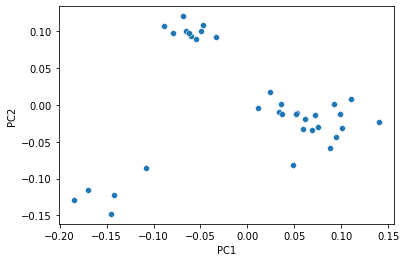

In [37]:
_ = sns.scatterplot(x=sequence_pcoa_ordination.samples['PC1'], 
                    y=sequence_pcoa_ordination.samples['PC2'])

That plot becomes more informative when we integrate sample labels, but like polar ordination, those sample labels were not used in the PCoA computation.

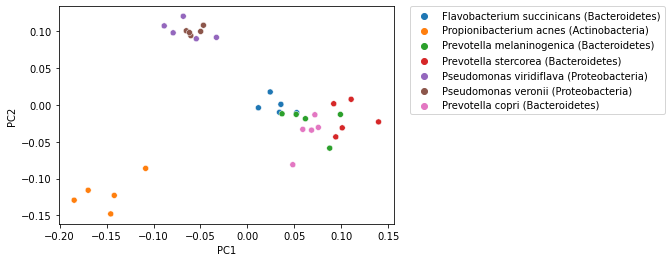

In [38]:
_ = sns.scatterplot(x=sequence_pcoa_ordination.samples['PC1'], 
                    y=sequence_pcoa_ordination.samples['PC2'], 
                    hue=sequence_labels['legend entry'])
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

PCoA (and other) ordination plots are often used in exploratory analysis, for example to see if sample similarity is associated with categories of metadata. This can be achieved by altering the metadata category that is used to define the coloring of samples in the plot. For example, in the following plot samples are colored by phlyum. Comparing this with the plot above, where samples are colored by genus and species, illustrates that samples cluster more distinctly by phylum than by species.

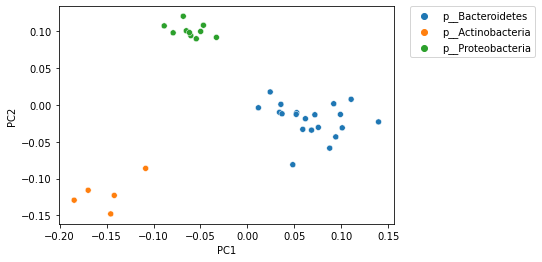

In [39]:
_ = sns.scatterplot(x=sequence_pcoa_ordination.samples['PC1'], 
                    y=sequence_pcoa_ordination.samples['PC2'], 
                    hue=sequence_labels['phylum'])
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

While in the examples presented here we have looked at the first two ordination axes, ordination methods typically generate many axes. The exact number of axes differs by method, but it's generally a function of the number of samples in the analysis. Ordination axes are typically ordered by the amount of variation in the data that is explained, so the first axis explains more varation than the second; the second axis explains more variation than the third; and so on. For that reason, visualization of ordination plots typically focus on the first two or three axes. It's possible to view additional axes however, and these may illustrate different patterns in your data. Typically however you will want to focus on the first few axes as the latter axis may be misleading if they explain relatively small amounts of variation. The following plot illustrates PCoA axis 1 versus PCoA axis 3, where the previous plots illustrate PCoA axis 1 versus PCoA axis 2.

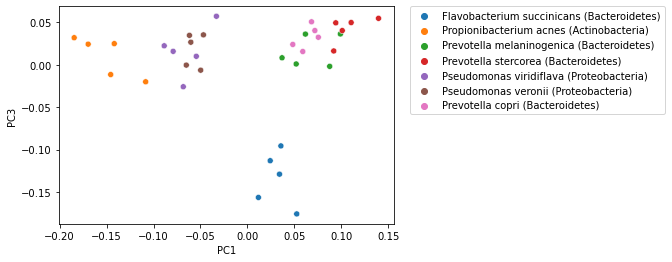

In [40]:
_ = sns.scatterplot(x=sequence_pcoa_ordination.samples['PC1'], 
                    y=sequence_pcoa_ordination.samples['PC3'], 
                    hue=sequence_labels['legend entry'])
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

```{warning}
Exploratory analysis of ordination data does not replace statistical comparisons of sample composition, and identifying a pattern in an ordination plot and subsequently testing whether it's significant is not the same as having an a priori hypothesis about how your samples will group and then testing for that statistically. If you have many metadata categories, and especially if you have relatively few samples, it's likely that spurious patterns may present themselves. **You should consider observations that result from exploratory analysis of ordination plots as hypotheses that can subsequntly be tested with different data.** Remember: exploratory analysis is a tool for hypothesis generation, and hypotheses generation and hypothesis testing cannot be performed on the same data.
```

Emperor {cite}`Vazquez-Baeza2013-ss` is a widely used tool for visualizing ordination plots, and it makes interactive exploratory analysis of PCoA plots very straight-forward. For example, coloring samples by different metadata categories, comparing different ordination axes, and inverting ordination axes are all possible to do with a few mouse clicks. Emperor is a great place to get started when doing your own exploratory analysis of ordination plots. 

```{admonition} Exercise
How does the clustering of samples compare between polar ordination and PCoA?
```

## Supervised classification

We'll continue our exploration of machine learning approaches with **supervised classification**, and specifically with an algorithm called **Naive Bayes**.  We'll implement Naive Bayes to gain an understanding of how it works. Like Polar Ordination, the math involved in Naive Bayes is relatively straight-forward, which is why I chose this algorithm to present here. There are many machine algorithms with more complex math, but Naive Bayes is widely used and powerful, so I think it's a great place to get started. 

We'll explore supervised classification in the context of a now familiar topic: taxonomic classification of 16S rRNA sequences. We previously explored this problem in {doc}`database-searching`, so it's worth spending a few minutes skimming that chapter if it's not fresh in your mind.

Briefly, the problem that we are going to address here is as follows. We have a query sequence ($q_i$) which is not taxonomically annotated (meaning we don't know the taxonomy of the organism whose genome it is found in), and a reference database ($R$) of taxonomically annotated sequences ($r_1, r_2, r_3, r_n$). We want to infer a taxonomic annotation for $q_i$. In {doc}`database-searching`, we solved this problem using pairwise sequence alignment. Here, we'll build a Naive Bayes classifier from our sequence feature table and labels, and then apply that classifier to unlabeled data.

### Defining a classification task

In a classification task, there are two or more pre-defined classes, and the goal is to assign observations to those classes. As humans, we perform these kinds of tasks everyday. For example, if you're browsing a bookstore you might classify titles as ones you want to read versus everything else (the ones you're not interested in reading). You might group the apps that you have on your phone into folders by classifying them by category (e.g., "school", "entertainment", or "social media"). 

When we're working with large data sets, supervised classification algorithms can help us with classification tasks that will make us more efficient or help us understand our data. A classic example of this outside of bioinformatics is an email spam filter. For every email that is received, the spam filter must define it as spam or not spam so the message can directed either to the user's spam folder or the user's inbox. The stakes can be high: a filter that is too permissive will cause the user's inbox to get filled with junk mail, while a filter that is overly restrictive could cause relevant messages to be directed to the spam folder. In either case, the email user could miss important messages.

In the taxonomic assignment example that we'll work through in this chapter, our classes will be microbial species. Our species classifier for 16S rRNA sequences will take an unannotated sequence as input and as output present the species that the sequence most likely originated from.

### Training data, test data, and cross-validation

Supervised classification algorithms need to be provided with data that is used to develop a model for use in classification. Developing this model is referred to as training the classifier. The data that is used for this is a collection of observations with defined classes, and is referred to as the **training data**. These labeled examples are the "supervision" aspect of supervised learning. In the email spam filter example, this would be email messages that are annotated as either spam or not spam. In the species assignment example, this would be 16S sequences that are taxonomically annotated at the species level. It is typically important that the training data be balanced - in other words, that there are roughly the same number of examples of each class.

In addition to the training data, an independent collection of observations with defined classes is needed as **test data**. These observations are not used to train the classifier, but rather to evaluate how the classifier performs on previously unseen data. The goal of testing the classifier on these test data is to predict what performance will be on **real world** data. Real world data refers to data for which the class is currently unknown. In the spam filter example, real world data would be new emails that you are receiving. In the species assignment example, real world data could be sequences that you obtain from the environment using a DNA sequencing instrument. The test data shouldn't be used for optimization of classifiers: in other words, you shouldn't develop a classifier on training data, test it on test data, go back and make changes to the classifier, and then re-test on test data. This would risk **over-fitting** the classifier to a particular test data set and performance on that test data may no longer be predictive of how the classifier will perform when it is used on real world data. 

Because training and test data sets can be very costly to develop (for example, they may require many hours of annotation by humans) we often use an approach called **k-fold cross validation** during classifier development and optimization {numref}`cross-validation-1`. In k-fold cross-validation, the training data is split into `k` different data sets, where `k` is usually five or ten. In each of the data sets, $1/k$ of the entries are used as test data and all of the other entries are used as training data. In `k` iterations, the classifier is developed on the training data and tested on the test data. The average performance of the classifier is then computed across the `k` iterations. k-fold cross validation therefore allows for developing and optimizing a classifier without using dedicated test data.

```{figure} ./images/ml-cross-validation.png
---
name: cross-validation-1
---
An illustration of k-fold cross validation where a single data set is split into k independent training and test data sets. Each circle represents a labeled entry for use in training or testing, and colors indicate the class of each entry. In the case of a spam filter, for example, red circles might represent spam messages while green circles represent messages that are not spam.
Image source: [Gufosowa](https://commons.wikimedia.org/wiki/File:K-fold_cross_validation_EN.svg), [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0), via Wikimedia Commons.
```

### Evaluating a binary classifier 

As mentioned above, in a classification task there are two or more pre-defined classes. A binary classifier would be a specific type of classifier for which there are exactly two classes - for example, spam and not spam. We'll start talking about how classifiers are evaluated by discussing binary classifiers because they're the easiest to understand. 

Imagine we're building a classifier that attempts to predict whether an individual is healthy or has some specific disease (let's call it *Disease X*). Perhaps the data that the classifier uses is based on a variety of medical data that has undergone a feature extraction process to generate features that can be used by a supervised classification algorithm. When a classifier is developed, you can think of it like a function that will take a collection of features for a sample and return a value of "healthy" or "diseased". 

The goal of our classifier is to serve as a diagnostic tool that identifies whether a patient has Disease X based on features of their medical data. A positive test result therefore indicates that the patient has Disease X while a negative test result indicates that they are healthy. When we apply our classifier to test data (i.e., where we know the correct class), there are a few possible outcomes. 

* The classifier predicts a positive test result, and the sample is known to come from a patient with Disease X. This is a **true positive (TP)**. 
* The classifier predicts a positive test result, and the sample is known to come from a healthy patient. This is a **false positive (FP)**. FPs are also referred to as type 1 errors.
* The classifier predicts a negative test result, and the sample is known to come from a patient with Disease X. This is a **false negative (FN)**. FNs are also referred to as type 2 errors.
* The classifier predicts a negative test result, and the sample is known to come from a healthy patient. This is a **true negative (TN)**. 

A classifier would typically be evaluated by running it on many samples and tallying the count of TP, FP, FN, and TN results. These tallies are typically presented in a structure known as a **confusion matrix**. For the confusion matrix, there many different values that can be computed which inform us of some aspect of classifier performance. 

The simplest way to think about evaluating the performance of our classifier from a confusion matrix is to compute its **accuracy** as:

```{math}
:label: accuracy
accuracy = \frac{TP + TN}{TP + FP + FN + TN}
```

In words, accuracy can be defined as the fraction of the total test cases that the classifier classified correctly. Accuracy gives us an idea of the classifier performance, but it hides some potentially relevant information from us. Specifically, it doesn't tell us whether poor classifier performance is a result of primarily Type 1 errors, primarily Type 2 errors, or a balance of the two. A low accuracy classifier could, for example, frequently return false positives (Type 1 errors) but almost never return false negatives (Type 2 errors). Such a classifier could still be a clinically useful tool. Because false negatives are very infrequent but false positives are common, that means when the classifier indicates a negative test result that person doesn't have the disease. If the classifier indicates a positive result, that could be an indicator that additional testing is needed. Of course we would rather our classifier achieve fewer false positives, but if this is a very cheap test and the additional tests are more expensive, it can be a useful first screening approach. 

Two other metrics are more widely used for evaluating classifiers, and these are typically computed as a pair. These metrics are **precision** and **recall** and they are more informative than accuracy because they indicate whether a classifier might suffer more from false positives or false negatives. 

Precision is the fraction of the positives reported by the classifier that are actually positives, or:

```{math}
:label: precision
precision = \frac{TP}{TP + FP}
```

Recall is the fraction of the actual positives that are reported to be positive by the classifier, or:

```{math}
:label: recall
recall = \frac{TP}{TP + FN}
```

Precision thus tells us how frequently our classifier yields false positives, while recall tells us how frequently our classifier yields false negatives. We of course would always like both of these values to be high, but depending on the application of our classifier, we may prefer high precision over high recall, or we may prefer high recall over high precision. 

### Naive Bayes classifiers

In this chapter, instead of using sequence alignment to identify the most likely taxonomic origin of a sequence, we'll train Naive Bayes classifiers to do this by building {ref}`kmer <kmer>`-based models of the 16S sequences of taxa in our training data. We'll then run test sequences through those models to identify the most likely taxonomic origin of each test sequence. Since we know the taxonomic origin of our test sequences, we can evaluate the accuracy of our classifiers by seeing how often they return the known taxonomy assignment. If our training and testing approaches are well-designed, the performance on our tests will inform us of how accurate we can expect our classifier to be on data where the actual taxonomic origin is unknown. 

### Training a Native Bayes classifier 

Naive Bayes classifiers work by building a model of what different classes look like based on labeled training data. As with unsupervised learning tasks, the starting point is a feature table representing instances of the different classes. In addition to the feature table, since this is a supervised learning task, the sequence labels (i.e., the class labels) will also be used to train the classifier.

We'll again use k-mers as our features, and continue with the value of `k` that we defined above. The first thing our Naive Bayes classifier will need is the set of all possible features, which in our case will be all possible words of length `k`. This will be dependent on the value of `k` and the characters in our alphabet (i.e., the characters that we should expect to find in the sequences in our reference database). This set is referred to as `W`, and can be computed as follows.

In [41]:
alphabet = skbio.DNA.nondegenerate_chars

def compute_W(alphabet, k):
    return set(map(''.join, itertools.product(alphabet, repeat=k)))

W = compute_W(alphabet, k)

print('Alphabet contains the characters: %s' % ', '.join(alphabet))
print('For an alphabet size of %d, W contains %d length-%d kmers.' % (len(alphabet), len(W), k))

Alphabet contains the characters: G, A, T, C
For an alphabet size of 4, W contains 256 length-4 kmers.


```{admonition} Exercise
Given the DNA alphabet (A, C, G, and T), how many different kmers of length 3 are there (i.e., 3-mers)? How many different 5-mers are there? How many 5-mers are there if there are twenty characters in our alphabet (as would be the case if we were working with protein sequences instead of DNA sequences)?
```

To train our taxonomic classifier, we also need to know what level of taxonomic specificity we want to classify our sequences to. We should expect to achieve higher accuracy at less specific taxonomic levels such as phylum or class, but these are likely to be less informative biologically than more specific levels such as genus or species. Again, we'll mirror the choice we made for our unsupervised learning task and attempt to build a species classifier here. 

With this information, we can next compute our **k-mer probability table**. The goal for this table is that it accurately represents the probability of observing each k-mer in `W` in a sequence from a given species. Because we don't know these probabilities, we estimate them based on the frequency that we observe each k-mer in the sequences in our training data. Our k-mer probability table is computed using the following values:

$N$ : The total number of sequences in the training data.

$W$: The set of all possible kmers, given $k$ and an alphabet.

$w_i$: An individual k-mer in $W$.

$n(w_i)$ : The total number of training data sequences containing $w_i$.

$P_i$ : The probability of observing $w_i$ in a relevant real world sequence from any species. Initially it might seem as though this would be computed as $n(w_i) / N$, but this neglects the possibility that a k-mer in a real world sequence might not be represented in any sequences in our training data (i.e., $n(w_i) = 0$). This would cause a problem when classifing that real world sequence - we'll revisit this shortly. As a result, 0.5 is added to the numerator and 1 is added to the denominator so that this is computed as $(n(w_i) + 0.5) / (N + 1)$. When we add to our counts in this way, we refer to the values that we're adding as **pseudocounts**. 

$P(w_i | species)$ : The probability of observing $w_i$ in a relevant real world sequence from a given species. Again, it would seem that this would be computed as the proportion of sequences in the species containing $w_i$, but this would neglect that we're likely to observe k-mers in real-world sequences that are not represented in our training data. A pseudocount is therefore added again to the numerator and denominator. This time the pseudocount in the numerator is scaled by how frequent $w_i$ is in the reference database as a whole: specifically, it is $P_i$. The pseudocount in the denominator is still 1. 

Our "kmer probability table" is $P(w_i | species)$ computed for all kmers in W and all species represented in our reference database. Let's compute that, and then look at the first 25 rows.

In [42]:
def compute_kmer_probability_table(feature_table, sequence_labels, W):
    N = feature_table.shape[0] # number of training sequences

    # number of sequences containing kmer wi
    n_wi = pd.Series(0, index=W)
    n_wi = n_wi + feature_table.astype(bool).sum(axis=0)
    n_wi = n_wi.fillna(0)
    n_wi.name = 'n(w_i)'

    # probabilities of observing each kmer
    Pi = (n_wi + 0.5) / (N + 1)
    Pi.name = 'P_i'
    
    # number of times each taxon appears in training set
    taxon_counts = collections.Counter(sequence_labels)
    taxon_table = pd.DataFrame(0, index=taxon_counts.keys(), columns=W)
    taxon_table = taxon_table + feature_table.astype(bool).groupby(by=sequence_labels, axis=0).sum()
    taxon_table = taxon_table.fillna(0)
    
    # probabilities of observing each kmer in each taxon
    p_wi_t = []
    for taxon, count in taxon_counts.items():
        p_wi_t.append(pd.Series((taxon_table.loc[taxon] + Pi) / (count + 1), name=taxon))

    return pd.DataFrame(p_wi_t).T

In [43]:
kmer_probability_table = compute_kmer_probability_table(sequence_feature_table, sequence_labels['legend entry'], W)
kmer_probability_table[:25]

,Flavobacterium succinicans (Bacteroidetes),Propionibacterium acnes (Actinobacteria),Prevotella melaninogenica (Bacteroidetes),Prevotella stercorea (Bacteroidetes),Pseudomonas viridiflava (Proteobacteria),Pseudomonas veronii (Proteobacteria),Prevotella copri (Bacteroidetes)
AAAA,0.368056,0.201389,0.534722,0.201389,0.034722,0.034722,0.034722
AAAC,0.974537,0.974537,0.974537,0.974537,0.307870,0.807870,0.974537
AAAG,0.997685,0.997685,0.997685,0.997685,0.997685,0.997685,0.997685
AAAT,0.891204,0.224537,0.057870,0.724537,0.057870,0.224537,0.224537
AACA,0.974537,0.974537,0.641204,0.974537,0.641204,0.807870,0.974537
AACC,0.784722,0.951389,0.951389,0.951389,0.118056,0.284722,0.951389
AACG,0.997685,0.997685,0.997685,0.997685,0.997685,0.997685,0.997685
AACT,0.997685,0.997685,0.997685,0.997685,0.997685,0.997685,0.997685
AAGA,0.965278,0.965278,0.965278,0.131944,0.965278,0.798611,0.798611
AAGC,0.789352,0.956019,0.122685,0.456019,0.956019,0.956019,0.956019


This k-mer probability table represents our k-mer-based models of the species in our training data. We can use this table to compute probabilities of real world sequences belonging to each of the species represented in this table.

### Applying a Naive Bayes classifier 

With our k-mer probability table we are now ready to classify unknown sequences. We'll begin by selecting sequences that will serve as our test data. We'll pull sequences for our species of interest at random from our reference database, excluding sequences that were used in our training data.

In [44]:
test_seq_data = load_annotated_sequences(taxa_of_interest, class_size=sequences_per_taxon, 
                                          verbose=False, ids_to_exclude=sequence_labels.index)
test_labels = feature_labels_from_sequence_records(test_seq_data)

We can now review a few of the sequences that were selected for our test data set.

In [45]:
for sr in random.sample(list(test_seq_data.values()), 3):
    print(sr.identifier)
    print(sr.taxonomy)
    print(sr.sequence)
    print('🦠')

711843
k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__succinicans
AGAGTTTGATCCTGGCTCAGGATGAACGCTAGCGGCAGGCTTAACACATGCAAGTCGAGGGGTATAGTTCTTCGGAACTAGAGACCGGCGCACGGGTGCGTAACGCGTATGCAATCTACCTTTTACAGAGGGATAGCCCAGAGAAATTTGGATTAATACCTCATAGTATATAGCCCTGGCATCAGGATTATATTAAAGTCACAACGGTAAAAGATGAGCATGCGTCCCATTAGCTAGTTGGTAAGGTAACGGCTTACCAAGGCTACGATGGGTAGGGGTCCTGAGAGGGAGATCCCCCACACTGGTACTGAGACACGGACCAGACTCCTACGGGAGGCAGCAGTGAGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCGTGCAGGATGACGGTCCTATGGATTGTAAACTGCTTTTATACGAGAAGAAACATCCCGACGTGTCGGGACTTGACGGTATCGTAAGAATAAGGATCGGCTAACTCCGTGCC
🦠
521268
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__melaninogenica
TAGAGTTTGATCCTGGCTCAGGATGAACGCTAGCTACAGGCTTAACACATGCAAGTCGAGGGGAAACGGGATTGATGGCTTGCACTCTTTGGACGTCCACCGGCGCAGGGGAGGGTAACGCATATCCACCCTTCCCATTACTGGGGGATAACCTGCAGAAAGGCACACTATCACGACGTAATCTTCTATGATCGGGTCATATTTGAAGTAAAGATTTATCGGTAATGGATGGGGATGCGTCTGATTATGTT

For a sequence that is provided as input to our Naive Bayes classifier, which is generally referred to as a query sequence, taxonomy will be assigned as follows. First, the set of all k-mers will be extracted from the query sequence. This set of k-mers is referred to as $V$. Then, for each species represented in the k-mer probability table, the probability of observing the sequence will be computed assuming that the sequence is a representative of that species. This is referred to as the probability of the query sequence given the species, or $P(query | species)$. This is computed as the product of all its k-mer probabilities for the given species. It should be clear based on this formula why it was necessary to add pseudocounts when computing our k-mer probability table. If not, k-mer probabilities of zero would result in a zero probability of the sequence being derived from that taxon at this step.

After computing $P(query | species)$ for each species, the taxonomy assignment returned is simply the one achieving the highest probability. Here we'll classify a sequence and look at the resulting taxonomy assignment.

In [46]:
# This function classifies a sequence that has already been split into a list
# of kmers.
def classify_V(V, kmer_probability_table):
    P_S_t = [] # probability of the sequence given the taxon
    for taxon in kmer_probability_table:
        kmer_probabilities = kmer_probability_table[taxon]
        # TODO: Confirm this step
        # Because we're multiplying many probabilities, we often will hit the lower
        # limit of the computer's precision (i.e., our probability will be 
        # less than machine epsilon). We therefore take the log of each observed 
        # probability and sum those logs. 
        query_log_probability = sum(list(map(np.log, kmer_probabilities[V])))
        P_S_t.append((query_log_probability, taxon))
    return max(P_S_t)[1], V

# This function is more convenient to use. It classifies a sequence 
# directly, first by computing V, and then by calling classify_V.
def classify_sequence(query_sequence, kmer_probability_table, k):
    V = list(map(str, query_sequence.iter_kmers(k=k)))
    return classify_V(V, kmer_probability_table)

We can now apply the Naive Bayes classifier to sequences in our test data set. Here I select a single test sequence, and then provide that as input to the `classify_sequence` function.

In [47]:
def random_sequence_record_choice(sequence_records):
    return random.sample(list(sequence_records.values()), 1)[0]

query_sr = random_sequence_record_choice(test_seq_data)
taxon_assignment, V = classify_sequence(query_sr.sequence, kmer_probability_table, k)
print("Sequence %s is predicted to be from the species %s." % (query_sr.identifier, taxon_assignment))

Sequence 4465561 is predicted to be from the species Prevotella melaninogenica (Bacteroidetes).


Because this query sequence is from our test data, we know the actual taxonomy assignment as we can look it up to determine if our classifier was correct. This is in contrast to applying our classifier to real world query sequences, where we typically won't know what the correct assignment in. We can use our test data to estimate how well we expect our classifier to perform on real world data.

In [48]:
print("Sequence %s is known to be from the species %s." % (query_sr.identifier, test_labels['legend entry'][query_sr.identifier]))

Sequence 4465561 is known to be from the species Prevotella melaninogenica (Bacteroidetes).


```{admonition} Exercise
Was this sequence classified as the correct species? If not, was it at least classified to the correct genus? What about the correct phylum?
```

```{admonition} Exercise
Try classifying a few other query sequences and determining if the returned species assignment was correct. You can do this by running the previous two code cells over again in order. Does this classifier seem to be working well?
```

### Evaluating our confidence in the results of the Naive Bayes classifier

Because the training and test sequences that we're working with were randomly selected from the full reference database, each time you run this notebook you should observe different results. If you run the above steps multiple times you'll get the wrong taxonomy assignment at least some of the time, most likely. Up to this point, we've left out an important piece of information: how confident should we be in our assignment? In other words, how dependent is our taxonomy assignment on our specific query sequence? If there were slight differences in our query sequence (e.g., because we observed a very closely related organism, such as one of the same species but a different strain, or because there are some sequencing errors in our sequence) would we obtain the same taxonomy assignment? If so, we should have higher confidence in our assignment. If not, we should have lower confidence in our assignment. This is important because our classifier as implemented so far will _always_ return one of the classes, even if our query sequence is very different than any of the sequences in our reference database.

We can quantify confidence in our taxonomic assignments using an approach called bootstrapping. With a bootstrap approach, we'll get our taxonomy assignment as we did above, but then for some user-specified number of iterations, we'll create random subsets of $V$ sampled with replacement. We'll then assign taxonomy to each random subset of $V$, and count the number of times the resulting taxonomy assignment is the same as the one we received when assigning taxonomy to $V$. The count of times that they are the same divided by the number of iterations we've chosen to run will be our confidence in the assignment. If the assignments are often the same we'll have a high confidence value, up to a maximum confidence value of 1 if the assignments are always the same. If the assignments are often different we'll have a low confidence value, down to a minimum value of 0 if the assignments are never the same. 

The following funtion will assign taxonomy to a query sequence, and will compute and return a confidence value for the assignment.

In [49]:
def classify_sequence_with_confidence(query_sequence, kmer_probability_table, k,
                                      confidence_iterations=100):
    # classify the query sequence, as we did above
    taxon, V = classify_sequence(query_sequence, kmer_probability_table, k)

    count_same_taxon = 0
    # Define the size of each subsample as 10% of the actual number of
    # kmers in the query sequence.
    subsample_size = int(len(V) * 0.1)
    # Perform n iterations (where n is provided by the user as 
    # confidence_iterations) where a random subset of the query sequence's
    # kmers are used for the classification task.
    # Keep track of the number of times the observed result is the same as
    # that for the query sequence. 
    for i in range(confidence_iterations):
        subsample_V = np.random.choice(V, subsample_size, replace=True)
        subsample_taxon, _ = classify_V(subsample_V, kmer_probability_table)
        if taxon == subsample_taxon:
            count_same_taxon += 1
    confidence = count_same_taxon / confidence_iterations

    return (taxon, confidence)

We can apply this to a randomly selected sequence from our test data as follows.

In [50]:
query_sr = random_sequence_record_choice(test_seq_data)
taxon_assignment, confidence = classify_sequence_with_confidence(query_sr.sequence, kmer_probability_table, k)
print(taxon_assignment)
print(confidence)
print("Sequence %s is predicted to be from the species %s. Confidence in this assignment is: %1.2f." % (query_sr.identifier, taxon_assignment, confidence))

Prevotella stercorea (Bacteroidetes)
0.75


Sequence 326403 is predicted to be from the species Prevotella stercorea (Bacteroidetes). Confidence in this assignment is: 0.75.


In [51]:
print("Sequence %s is known to be from the species %s." % (query_sr.identifier, test_labels['legend entry'][query_sr.identifier]))

Sequence 326403 is known to be from the species Prevotella stercorea (Bacteroidetes).


```{admonition} Exercise
Was this sequence classified as the correct species? Does the confidence value align with this result?
```

At first glance, we don't necessarily have an idea of what good versus bad confidence scores are, but we can use our test data to explore that. Once we know what a good confidence score is, we can apply a confidence threshold that we can use in our work. For example, we can define a confidence threshold above which we would accept a taxonomy assignment and below which we could label a sequence as "unclassified". To explore this, let's compute taxonomy assignments and confidence for all of our test sequences and then see what the distributions of confidence scores look like for correct assignments and incorrect assignments.

In [52]:
correct_assignment_confidences = []
incorrect_assignment_confidences = []
summary = []

for query_id, query_sr in test_seq_data.items():
    predicted_taxonomy, confidence = classify_sequence_with_confidence(query_sr.sequence, kmer_probability_table, k)
    known_taxonomy = test_labels['legend entry'][query_sr.identifier]
    correct_assignment = known_taxonomy == predicted_taxonomy
    if correct_assignment:
        correct_assignment_confidences.append(confidence)
    else:
        incorrect_assignment_confidences.append(confidence)

    summary.append([predicted_taxonomy, known_taxonomy, confidence, correct_assignment])

summary = pd.DataFrame(summary, columns=['Predicted taxonomy', 'Known taxonomy', 'Confidence', 'Correct assignment'])

summary

,Predicted taxonomy,Known taxonomy,Confidence,Correct assignment
0,Flavobacterium succinicans (Bacteroidetes),Flavobacterium succinicans (Bacteroidetes),0.91,True
1,Flavobacterium succinicans (Bacteroidetes),Flavobacterium succinicans (Bacteroidetes),0.84,True
2,Flavobacterium succinicans (Bacteroidetes),Flavobacterium succinicans (Bacteroidetes),0.68,True
3,Flavobacterium succinicans (Bacteroidetes),Flavobacterium succinicans (Bacteroidetes),0.73,True
4,Flavobacterium succinicans (Bacteroidetes),Flavobacterium succinicans (Bacteroidetes),0.81,True
5,Propionibacterium acnes (Actinobacteria),Propionibacterium acnes (Actinobacteria),0.81,True
6,Propionibacterium acnes (Actinobacteria),Propionibacterium acnes (Actinobacteria),0.36,True
7,Propionibacterium acnes (Actinobacteria),Propionibacterium acnes (Actinobacteria),0.61,True
8,Propionibacterium acnes (Actinobacteria),Propionibacterium acnes (Actinobacteria),0.91,True
9,Propionibacterium acnes (Actinobacteria),Propionibacterium acnes (Actinobacteria),0.70,True


Comparing distributions of confidence scores for correct and incorrect assignments is possible from the table above, and the table provides details that can be useful in assessing when the classifier is working well and when it isn't. A couple of boxplots however will make comparing these distributions trivial.

<AxesSubplot:ylabel='Confidence'>

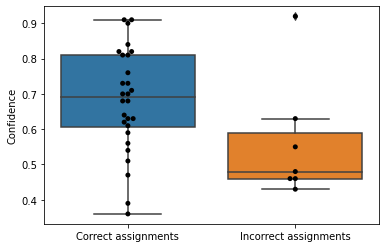

In [53]:
import seaborn as sns

ax = sns.boxplot(data=[correct_assignment_confidences, incorrect_assignment_confidences])
ax = sns.swarmplot(data=[correct_assignment_confidences, incorrect_assignment_confidences], color="black")
_ = ax.set_xticklabels(['Correct assignments', 'Incorrect assignments'])
_ = ax.set_ylabel('Confidence')

ax

What does this plot tell you about how well setting a confidence threshold is likely to work? If you never wanted to reject a correct assignment, how often would you accept an incorrect assignment? If you never wanted to accept an incorrect assignment, how often would you reject a correct assignment?

We can also compute the overall accuracy of our classifier as follows:

In [54]:
n_correct_assignments = len(correct_assignment_confidences)
n_incorrect_assignments = len(incorrect_assignment_confidences)
accuracy = n_correct_assignments / (n_correct_assignments + n_incorrect_assignments)
print('The accuracy of the classifier was %1.3f.' % accuracy)

The accuracy of the classifier was 0.800.


Finally, we can summarize how this classifier worked by creating a **confusion matrix**. A confusion matrix has two axes - one corresponding to the actual assignments and one corresponding to the predicted assignments. The values in the confusion matrix represent how each instance of each known taxonomy was classified. The order of the classes on the two axes should always be the same in a confusion matrix. A good classifier will then have high values along the diagonal. If classifier accuracy is not great, you can see which known classes were misassigned, or where the classifier got confused.

In [55]:
confusion_matrix = summary.groupby('Predicted taxonomy')['Known taxonomy'].value_counts().to_frame()
confusion_matrix.columns = ['count']
confusion_matrix = pd.pivot_table(confusion_matrix, index=['Predicted taxonomy'], columns=['Known taxonomy'], fill_value=0)
confusion_matrix

count  \
Known taxonomy                             Flavobacterium succinicans (Bacteroidetes)   
Predicted taxonomy                                                                      
Flavobacterium succinicans (Bacteroidetes)                                          5   
Prevotella copri (Bacteroidetes)                                                    0   
Prevotella melaninogenica (Bacteroidetes)                                           0   
Prevotella stercorea (Bacteroidetes)                                                0   
Propionibacterium acnes (Actinobacteria)                                            0   
Pseudomonas veronii (Proteobacteria)                                                0   
Pseudomonas viridiflava (Proteobacteria)                                            0   

                                                                             \
Known taxonomy                             Prevotella copri (Bacteroidetes)   
Predicted taxonomy                                                            
Flavobacterium succinicans (Bacteroidetes)                                0   
Prevotella copri (Bacteroidetes)                                          5   
Prevotella melaninogenica (Bacteroidetes)                                 0   
Prevotella stercorea (Bacteroidetes)                                      0   
Propionibacterium acnes (Actinobacteria)                                  0   
Pseudomonas veronii (Proteobacteria)                                      0   
Pseudomonas viridiflava (Proteobacteria)                                  0   

                                                                                      \
Known taxonomy                             Prevotella melaninogenica (Bacteroidetes)   
Predicted taxonomy                                                                     
Flavobacterium succinicans (Bacteroidetes)                                         0   
Prevotella copri (Bacteroidetes)                                                   0   
Prevotella melaninogenica (Bacteroidetes)                                          5   
Prevotella stercorea (Bacteroidetes)                                               0   
Propionibacterium acnes (Actinobacteria)                                           0   
Pseudomonas veronii (Proteobacteria)                                               0   
Pseudomonas viridiflava (Proteobacteria)                                           0   

                                                                                 \
Known taxonomy                             Prevotella stercorea (Bacteroidetes)   
Predicted taxonomy                                                                
Flavobacterium succinicans (Bacteroidetes)                                    0   
Prevotella copri (Bacteroidetes)                                              4   
Prevotella melaninogenica (Bacteroidetes)                                     0   
Prevotella stercorea (Bacteroidetes)                                          1   
Propionibacterium acnes (Actinobacteria)                                      0   
Pseudomonas veronii (Proteobacteria)                                          0   
Pseudomonas viridiflava (Proteobacteria)                                      0   

                                                                                     \
Known taxonomy                             Propionibacterium acnes (Actinobacteria)   
Predicted taxonomy                                                                    
Flavobacterium succinicans (Bacteroidetes)                                        0   
Prevotella copri (Bacteroidetes)                                                  0   
Prevotella melaninogenica (Bacteroidetes)                                         0   
Prevotella stercorea (Bacteroidetes)                                              0   
Propionibacterium acnes (Actinobacteria)                                     

If the classifier generated here got some classifications wrong, did the classifier at least assign the sequences to the correct phylum?

```{admonition} Exercise
Jump back up to where we [defined `k` and `taxonomic_level`](ml:define-k) and modify those values. How does the accuracy of the classifier change if you increase or decrease `k` while keeping the value of `taxonomic_level` fixed? How does the accuracy change if you increase or decrease the `taxonomic_level` while keeping `k` fixed? 
```

## Variations on the input to machine learning algorithms

As in the Iris dataset, the labels in our microbial data are discrete (i.e., categorical or qualitative) as opposed to continuous (i.e., quantitative). If our labels in a supervised learning project were continous instead of discrete - for example the abundance of an organism in an environment - we could still apply supervised learning, but we would work with different algorithms. Specifically, we'd used supervised regression algorithms, rather than supervised classification algorithms.  

Similarly, while the features we worked with in our unsupervised and supervised learning examples were continuous values, feature values could also be discrete (e.g., the sex of a subject, or the species of a specimen in an environment). The applicable algorithms might change, but machine learning techniques in general would still be available. 

scikit-learn provides other example datasets, including [the diabetes dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes), [the housing market dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#boston-house-prices-dataset) and [the hand-writing dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#optical-recognition-of-handwritten-digits-dataset). These are good illustrations of other types of data that can be used in machine learning tasks. The message to take away is that if you can wrangle your data into a feature table, potentially with corresponding sample labels, you will likely be able to apply machine learning techniques to that data. That said, and as I mentioned at the beginning of this chapter, this introduction barely scratches the surface of this complex branch of statistics and computer science. Especially with the accessibility of these methods through software like scikit-learn, it's easy to get to the point where you know enough to get yourself into trouble by using machine learning methods inappropriately. If you'd like to apply these tools in your research, you must continue your learning. I recommend continuing with [scikit-learn's documentation](https://scikit-learn.org/).

## List of works cited

```{bibliography} ./references.bib
:filter: docname in docnames
```